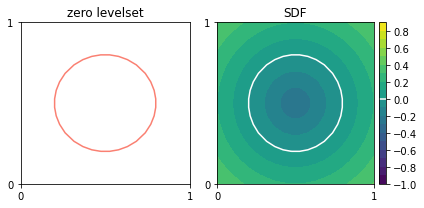

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline
from typing import Callable, Sequence
import functools as ft
import optax
import treex as tx
from sdf_jax.discretize import discretize2d
from sdf_jax.util import plot2d

def sdf_sphere(x, radius=0.3, center=jnp.array([0.5, 0.5])):
    return jnp.linalg.norm(x - center) - radius

plot2d(sdf_sphere, ngrid=20)

In [2]:
class SimpleNeuralSDF(tx.Module):
    def __init__(self, dims: Sequence[int], act: Callable):
        self.dims = dims
        self.act = act
    @tx.compact
    def __call__(self, x):
        assert x.ndim == 1
        for dim in self.dims:
            x = tx.Linear(dim)(x)
            x = self.act(x)
        y = tx.Linear(1)(x)
        return y[0]

@ft.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, model, x, y):
    model = model.merge(params)
    preds = jax.vmap(model)(x)
    loss = jnp.mean(jnp.abs(preds - y) / (jnp.abs(y) + 0.01))
    return loss, model

@jax.jit
def train_step(model, x, y, optimizer):
    params = model.filter(tx.Parameter)
    (loss, model), grads = loss_fn(params, model, x, y)
    new_params = optimizer.update(grads, params)
    model = model.merge(new_params)
    return loss, model, optimizer

def print_callback(step, loss, model, optimizer):
    print(f"[{step}] loss: {loss:.4f}")

def fit(
    sdf=sdf_sphere,
    ngrid=20,
    # module
    dims=[64,64],
    act=jax.nn.relu,
    # optimizer
    key=jrandom.PRNGKey(1234),
    lr=5e-3,
    steps=1000,
    # utils
    cb=print_callback,
    cb_every=100,
):
    xs, ys = discretize2d(sdf, ngrid=ngrid, x_lims=(0,1), y_lims=(0,1))
    xs = xs.reshape(-1, 2)
    ys = ys.reshape(-1)
    key, model_key = jrandom.split(key, 2)
    model = SimpleNeuralSDF(dims=dims, act=act).init(model_key, xs[0])
    optimizer = tx.Optimizer(optax.adam(lr))
    optimizer = optimizer.init(model.filter(tx.Parameter))
    for step in tqdm(range(steps)):
        loss, model, optimizer = train_step(model, xs, ys, optimizer)
        if step % cb_every == 0:
            cb(step, loss, model, optimizer)
    cb(step, loss, model, optimizer)
    return loss, model

In [3]:
loss, model = fit()

  0%|          | 0/1000 [00:00<?, ?it/s]

[0] loss: 1.4814
[100] loss: 0.3873
[200] loss: 0.7252
[300] loss: 0.1836
[400] loss: 0.1111
[500] loss: 0.1167
[600] loss: 0.0441
[700] loss: 0.1048
[800] loss: 0.1079
[900] loss: 0.0951
[999] loss: 0.0656


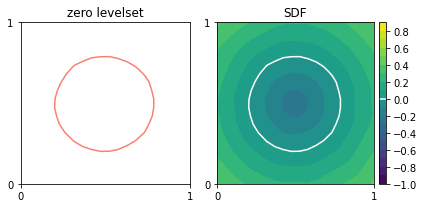

In [4]:
plot2d(model, ngrid=20)

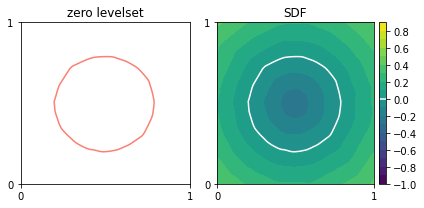

In [5]:
plot2d(model, ngrid=50)

  0%|          | 0/1000 [00:00<?, ?it/s]

[0] loss: 3.1693
[100] loss: 0.9963
[200] loss: 0.9578
[300] loss: 0.9396
[400] loss: 0.9412
[500] loss: 0.7396
[600] loss: 0.6499
[700] loss: 0.5657
[800] loss: 0.5315
[900] loss: 0.5191
[999] loss: 0.2325


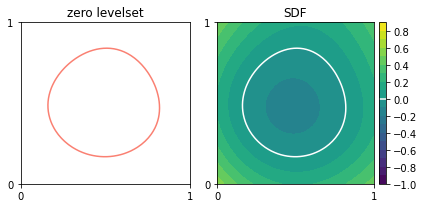

In [6]:
loss, model = fit(act=jax.nn.softplus, lr=5e-3)
plot2d(model, ngrid=50)

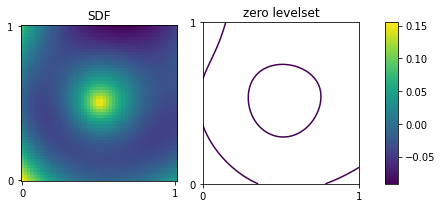

In [7]:
plot2d(lambda x: model(x) - sdf_sphere(x), ngrid=50)